In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Define Import Path

In [ ]:
# Get the current directory
current_dir = Path().absolute()

# Get folder path for model inputs
folder_path = current_dir / "Inputs"

## 2. Set Scenario Parameters

In [ ]:
# distance limit
max_dis = 300

# Sampling number
num_samples = 1000

# Generation technology
Gen_type = 'mswip'

# Sludge mix rate
# For scenario: W1
MaxiRate = 0.05 # Maximum mix rate of sludge mass in total fuel mass
l_ratio = 0.2 # the ratio of lower bound to Maximum mix rate 
# For scenario: W2
# MaxiRate = 0.2 
# l_ratio = 0.05

## 3. Define Export Path

In [ ]:
# Path for optimization results
folder_GHG = current_dir / f"Outputs/GHG_{Gen_type}_{num_samples}_M{MixRate}_L{l_ratio}_S2_V4"
os.makedirs(folder_GHG, exist_ok=True)

# Path for optimization logs
log_dir = folder_GHG / "logs"
os.makedirs(log_dir, exist_ok=True)

## 4. Data Import

In [ ]:
# MWWTP

file_WWTP = os.path.join(folder_path, "WWTP_45%wc.xlsx")
df_WWTP = pd.read_excel(file_WWTP)

In [ ]:
# MSWIP

file_MSWIP =  os.path.join(folder_path, " MSWIP.xlsx")
df_MSWIP = pd.read_excel(file_MSWIP)

file_plant_waste =  os.path.join(folder_path, "waste_inceration_plants_2020_operating.xlsx")
df_plant_waste = pd.read_excel(file_plant_waste)

In [ ]:
# distance

file_dis_MSWIP = os.path.join(folder_path, f"distance_mswip_nation_{max_dis}.csv")
df_dis_mswip = pd.read_csv(file_dis_MSWIP)

In [ ]:
# Provincal data

file_intesity =  os.path.join(folder_path, "province_intensity.xlsx")
df_intesity = pd.read_excel(file_intesity,usecols=['Province','GHG_emis_tCO2eq/kWh'])

In [8]:
# Costs for Monte Carlo Simulation

## Net costs
file_NC =  os.path.join(folder_path, f"NC_old_nation_{num_samples}_monthly.csv")
df_nc = pd.read_csv(file_NC)

## NC_cowaste
file_NC_cowaste =  os.path.join(folder_path, f"NC_cowaste_{num_samples}.xlsx")
df_NC_cowaste = pd.read_excel(file_NC_cowaste)

## 5. Input Data & Parameters

In [9]:
# GHG emission factors (water content: 45%)

GHG_SludgeInci = -0.3163 # sludge incineration with energy recovery (tCO2eq/t)
GHG_SludgeLandfill = 0.8672 # sanitary landfill (tCO2eq/t)
GHG_SludgeLandApp = (0.1065+0.3184)/2 # land application (tCO2eq/t)
GHG_SludgeBuild = -0.1701 # building material utilization (tCO2eq/t)
GHG_SludgeOther = 0.1124 #  other applications (tCO2eq/t)

GHG_SludgeBurn = 0.0798 # sludge burning on average (tCO2eq/t)
GHG_SludgeTrans = 0.123/1000 # sludge transport (tCO2eq/km)

GHG_Elec_province = dict(zip(df_intesity['Province'], df_intesity['GHG_emis_tCO2eq/kWh'])) # grid electricity (tCO2eq/kWh)

In [10]:
# The k-th MSWIP's GHG emission factor derived from local grid averages: GHG_Elec_waste[k] 

region_k = df_plant_waste['Pro_en']
GHG_Elec_waste = dict()
for k in range(len(region_k)):
    GHG_Elec_waste[k] = GHG_Elec_province[region_k[k]]

In [11]:
# The available volume of dewatered sludge generated by the i-th MWWTP in the m-th month: SludgeSupply[i,m] 
# The weighted average emission factor for original disposal approaches: SludgeTreatmentfactor[i,m]

month_WWTP = df_WWTP['Statistical month']
supply = df_WWTP['total_sludge_treated'] # Total sludge treated (ton/month, 45% moisture content)
landapp = df_WWTP['land_application']
building = df_WWTP['building_materials']
incineration = df_WWTP['incineration']
landfill = df_WWTP['landfill']
other = df_WWTP['other_disposal']
item = df_WWTP['Plantcode']

SludgeSupply = dict() 
SludgeTreatmentfactor = dict() 
wwtp_counter = 0

for k in range(len(month_WWTP)):
    m = int(month_WWTP[k])-202000-1
    SludgeSupply[wwtp_counter, m] = round(supply[k]/1000,2)
    
    if supply[k] == 0:
        SludgeTreatmentfactor[wwtp_counter, m] = round(0,2)
    else: SludgeTreatmentfactor[wwtp_counter, m] = round((landapp[k]*GHG_SludgeLandApp+building[k]*GHG_SludgeBuild+
                                                                 incineration[k]*GHG_SludgeInci+landfill[k]*GHG_SludgeLandfill+
                                                                 other[k]*GHG_SludgeOther)/supply[k],2)
     
    if m == 11:
        wwtp_counter = wwtp_counter + 1

In [12]:
# The weighted average net cost for original disposal approaches: NC_old[i,num]

NC_old = df_nc.set_index(['num', 'FID', 'm'])['value'].to_dict()

In [13]:
# The net cost for sludge co-firing in MSWIPs: NC_cowaste

NC_cowaste = dict()

for num in range(num_samples):
    NC_cowaste[num] = df_NC_cowaste['NC_cowaste'][num]

In [14]:
# The maximum monthly co-firing capacity for the k-th MSWIP: SludgeDemand_MSWIP[k,m]

month_MSWIP = df_MSWIP['Statistical month']
demand_MSWIP_1 = df_MSWIP['Monthly_Waste_Ele_t'] * MaxiRate
demand_MSWIP_2 = df_MSWIP['Monthly_Waste_Heat_t'] * MaxiRate
demand_MSWIP = demand_MSWIP_1 + demand_MSWIP_2

SludgeDemand_MSWIP = dict() 
mswip_counter = 0

for o in range(len(month_MSWIP)):
    m_w = int(month_MSWIP[o])-202000-1
    SludgeDemand_MSWIP[mswip_counter, m_w] = demand_MSWIP[o]/1000 
    
    if m_w == 11:
        mswip_counter = mswip_counter + 1

In [15]:
# The MWWTP-MSWIP distance: Distance_MSWIP[i,k] km
# The MWWTP-MSWIP distance for a given month: annual_Distance_MSWIP[i,k,m] km

distance_mswip = df_dis_mswip['distance']
WWTP = df_dis_mswip['INPUT_FID']
MSWIP = df_dis_mswip['NEAR_FID']

Distance_MSWIP = dict()
annual_Distance_MSWIP = dict()

for q in range(len(distance_mswip)):
    wwtp = int(WWTP[q])
    mswip = int(MSWIP[q])
    Distance_MSWIP[wwtp, mswip] = round(distance_mswip[q],2)
    
    for m in range(12):
        annual_Distance_MSWIP[wwtp,mswip,m] = round(distance_mswip[q],2) 

In [16]:
# MWWTP-MSWIP pairs involving the i-th MWWTP：WWTP_mswip_possiblelinkage[i]
# List of MWWTPs within economical transport distance：wwtp_mswip_list = []


WWTP_mswip_possiblelinkage = dict()
wwtp_mswip_list = []

for key in Distance_MSWIP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_mswip_possiblelinkage:
        WWTP_mswip_possiblelinkage[first_digit] = []  
        
    WWTP_mswip_possiblelinkage[first_digit].append(key)   
    
    if first_digit not in wwtp_mswip_list:
        wwtp_mswip_list.append(first_digit) 

In [17]:
# MWWTP-MSWIP pairs involving the i-th MWWTP for a given month：annual_WWTP_mswip_pl[i,m]：[(i,1,m),(i,8,m),....]

annual_WWTP_mswip_pl = dict()


for wwtp in wwtp_mswip_list:
    for m in range(12):
        annual_WWTP_mswip_pl[wwtp, m] = []

for key in annual_Distance_MSWIP.keys():
    digit_1 = key[0] # MMWTP
    digit_3 = key[2] # month
    annual_WWTP_mswip_pl[digit_1,digit_3].append(key)

In [18]:
# The potential MWWTP-MSWIP pairs involving the k-th MSWIP：MSWIP_possiblelinkage[k]:[(i,k)]
# List of MSWIPs within economical transport distance：mswip_list = []


MSWIP_possiblelinkage = dict()
mswip_list = []

for key in sorted(Distance_MSWIP.keys(), key=lambda x: x[1]): 
    second_digit = key[1]
    
    if second_digit not in MSWIP_possiblelinkage:
        MSWIP_possiblelinkage[second_digit] = [] 
        
    MSWIP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in mswip_list:
        mswip_list.append(second_digit)    

In [19]:
# MWWTP-MSWIP pairs involving the k-th MSWIP for a given month：annual_MSWIP_possiblelinkage[k,m]

annual_MSWIP_possiblelinkage = dict()


for mswip in mswip_list:
    for m in range(12):
        annual_MSWIP_possiblelinkage[mswip, m] = []

for key in annual_Distance_MSWIP.keys():
    digit_2 = key[1]
    digit_3 = key[2]
    annual_MSWIP_possiblelinkage[digit_2,digit_3].append(key)

## 6. Model Development and Optimization

In [20]:
# Define the model for 1000 Monte Carlo Simulation
# Unit：ktCO2eq, Thounsand CNY

def Optimize_GHG_01_Nation(num,log_filepath):

    # Model Parameters
    M = 12

    # Create a new model
    model = gp.Model(f"GHG_mswip_{num}")
    
    # Define the folder path of log file
    model.setParam("LogFile", log_filepath)
    
    # Create variables
    weight_mswip = model.addVars(annual_Distance_MSWIP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_mswip')
    z_mswip = model.addVars(mswip_list,vtype=GRB.BINARY, name='z_mswip')

    # Define the component of objective
    # onsite fuel combustion - waste
    obj1 = gp.quicksum(weight_mswip[mswip_index]*GHG_SludgeBurn 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge treatment - waste
    obj2 = gp.quicksum(-weight_mswip[mswip_index]*SludgeTreatmentfactor[mswip_index[0],mswip_index[2]] 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge dehydration - waste
    obj3 = gp.quicksum(weight_mswip[mswip_index]*28*GHG_Elec_waste[mswip_index[1]] 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge transport - waste
    obj4 = gp.quicksum(weight_mswip[mswip_index]*GHG_SludgeTrans*annual_Distance_MSWIP[mswip_index] 
                       for mswip_index in annual_Distance_MSWIP.keys())


    # Set objective
    model.setObjective(obj1+obj2+obj3+obj4,GRB.MINIMIZE)


    # Add constraints
    # Supply limit
    model.addConstrs(gp.quicksum(weight_mswip[wwtp_link] for wwtp_link in annual_WWTP_mswip_pl[i,m]) <= SludgeSupply[i,m] 
                     for i in wwtp_mswip_list for m in range(M))

    # Maximum Demand 
    model.addConstrs(gp.quicksum(weight_mswip[mswip_link] for mswip_link in annual_MSWIP_possiblelinkage[k,m]) <= SludgeDemand_MSWIP[k,m]*z_mswip[k]
                     for k in mswip_list for m in range(M))
    
    # Minimum Demand
    model.addConstrs(gp.quicksum(weight_mswip[mswip_link] for mswip_link in annual_MSWIP_possiblelinkage[k,m]) >= l_ratio*SludgeDemand_MSWIP[k,m]*z_mswip[k]
                     for k in mswip_list for m in range(M))
    
    # Economic Constraint : Economic feasibility constraints (by plant annual profit)
    model.addConstrs( 
        gp.quicksum(weight_mswip[mswip_link]* (Distance_MSWIP[mswip_link[0],k]*0.65-NC_old[num,mswip_link[0],m]+NC_cowaste[num])
                                for m in range(M) 
                                for mswip_link in annual_MSWIP_possiblelinkage[k,m]) <= 0 
                     for k in mswip_list
                    )

      # Set the MIPGap parameter to 0.01（1%）
    model.setParam('MIPGap', 0.005)
    
    # Optimize model
    model.optimize()
    
    # Obtain the objective value
    obj_expr = model.getObjective()
    obj_value = obj_expr.getValue()
    
  # Obtain the objective values of each life-cycle
    obj1_val = obj1.getValue()
    obj2_val = obj2.getValue()
    obj3_val = obj3.getValue()
    obj4_val = obj4.getValue()
    
    return model,weight_mswip,z_mswip,obj_value,obj1_val,obj2_val,obj3_val,obj4_val
    

In [ ]:
# Function Execution and Result Storage

unit_obj = []

for num in range(num_samples):

    log_filename = f"GHG_mswip_{num}.log"
    log_filepath = os.path.join(log_dir, log_filename)    
    

    model,weight_mswip,z_mswip,obj_value,obj1_val,obj2_val,obj3_val,obj4_val = Optimize_GHG_01_Nation(num,log_filepath)
         
        
   # Obtain the value of decision variables
    opt_weight = model.getAttr("X",weight_mswip)
    linkage = {key: value for key, value in opt_weight.items() if value > 0.0001}

    weight = []
    for key,value in linkage.items():
        i = key[0]
        k = key[1]
        m = key[2]
        weight.append([i, k, m, value]) 

    df_weight = pd.DataFrame(weight, columns=['I', 'K', 'M', 'opt_weight_mswip'])
    w_mswip = df_weight['opt_weight_mswip'].sum()
    
    excel_filename = os.path.join(folder_GHG, f"mswip_{num}.csv")
    df_weight.to_csv(excel_filename, index=False)
    
    opt_z_mswip = model.getAttr("X",z_mswip)
    z_mswip_val = {key: value for key, value in opt_z_mswip.items()}
    df_m_mswip = pd.DataFrame(list(z_mswip_val.items()), columns=['K', 'z_mswip'])
    df_m_mswip.to_csv(os.path.join(folder_GHG, f"z_mswip_{num}.csv"), index=False)
    
    n_mswip = df_m_mswip['z_mswip'].sum()
    
    unit_obj.append({
        'num':num,
        'obj_value':obj_value,
        'obj1': obj1_val,
        'obj2': obj2_val,
        'obj3': obj3_val,
        'obj4': obj4_val,
        'opt_weight_mswip':w_mswip,
        'n_mswip': n_mswip
        }) 
    
df_unit_obj = pd.DataFrame(unit_obj)

file_result = os.path.join(folder_GHG, f"result_01_{max_dis}.csv")
df_unit_obj.to_csv(file_result,index=False)

## 7. Overview of the Results

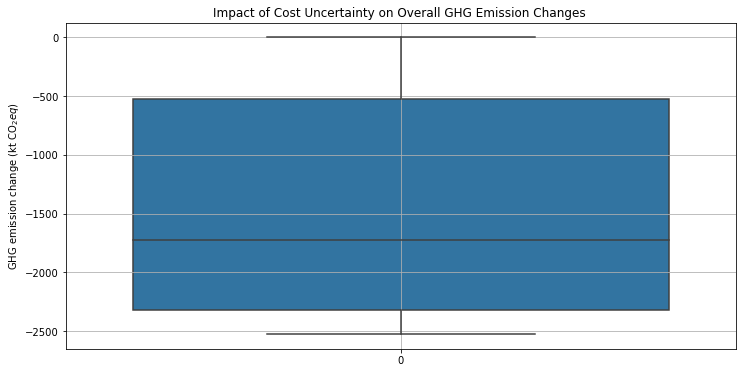

In [22]:
# Plot boxplots for mix_1 and mix_2 columns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_unit_obj['obj_value'])
plt.title('Impact of Cost Uncertainty on Overall GHG Emission Changes ')
plt.ylabel('GHG emission change (kt CO$_2eq$)')
plt.grid(True)

plt.savefig(folder_GHG / f'Overall GHG Emission Changes_{num_samples}.png')
plt.show()

## 8. Post-processing of Results

In [23]:
# Define the output folder of the processed results

output_path = os.path.join(folder_GHG, "num_processed")
os.makedirs(output_path, exist_ok=True)

In [24]:
origin_mswip = ['opt_weight_mswip' 
               ,'Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport'
               ,'Total_emission_change'
               ,'Transportation cost','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']

to_update_mswip = ['opt_weight_mswip'
               ,'GHGE_W1','GHGE_W2','GHGE_W3','GHGE_W4'
               ,'GHGE_Wtotal'
               ,'E_W1','E_W2','E_W3'
               ,'E_Wtotal']

column_map_mswip = dict(zip(to_update_mswip, origin_mswip))

province_order = ['Heilongjiang','Inner Mongolia','Jilin','Liaoning', # East Grid
                  'Gansu','Ningxia','Qinghai','Shaanxi','Xinjiang', # Northwest Grid
                  'Beijing','Hebei','Shandong','Shanxi','Tianjin', # North Grid
                  'Chongqing','Henan','Hubei','Hunan','Jiangxi','Sichuan',# Central Grid
                  'Anhui','Fujian','Jiangsu','Shanghai','Zhejiang', # Northeast Grid
                  'Guangdong','Guangxi','Guizhou','Hainan','Yunnan'] # South Grid

In [25]:
# to_dict - map

df_plant_wwtp = pd.read_excel(r"E:\Test\Inputs\wastewater_treatment_plants_5218.xlsx")
i_province = df_plant_wwtp.set_index('FID')['Pro_en'].to_dict()

k_province = df_plant_waste.set_index('FID')['Pro_en'].to_dict()
k_cl = df_plant_waste.set_index('FID')['Capacity_elec_MW'].to_dict()

In [26]:
I_total_by_num = []


for num in range(num_samples):

    file_mswip = os.path.join(folder_GHG,fr"mswip_{num}.csv")
    df_mswip = pd.read_csv(file_mswip)
    
    sum_mswip = df_mswip.groupby('I')['opt_weight_mswip'].sum().reset_index()
    sum_mswip['num'] = num
    I_total_by_num.append(sum_mswip)
    


    # Convert to MultiIndex DataFrame for easy lookup
    df_mswip.set_index(['I', 'K', 'M'], inplace=True)
    
    for col in origin_mswip[1:]:
        df_mswip[col] = 0
    df_mswip['distance'] = 0
    
    df_mswip['Fuel combustion'] = df_mswip['opt_weight_mswip']* GHG_SludgeBurn 
    opt_weight_mswip = df_mswip['opt_weight_mswip']
    for i, k, m in df_mswip.index:
        opt_weight = opt_weight_mswip.loc[(i, k, m)]
        df_mswip.loc[(i, k, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_mswip.loc[(i, k, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_waste[k] 
        df_mswip.loc[(i, k, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_MSWIP[i, k]
        
        df_mswip.loc[(i, k, m),'Transportation cost'] = opt_weight * Distance_MSWIP[i,k]*0.65 
        df_mswip.loc[(i, k, m),'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m] 
        df_mswip.loc[(i, k, m),'Co-combustion cost'] = opt_weight * NC_cowaste[num] 
        
        df_mswip.loc[(i, k, m),'distance'] = Distance_MSWIP[i,k] 
    
    df_mswip['Total_emission_change'] = df_mswip[['Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport']].sum(axis=1)  
    df_mswip['Economic_total'] = df_mswip[['Transportation cost','Sludge treatment fee','Co-combustion cost']].sum(axis=1)  


        
    df_mswip.reset_index(inplace=True)
    df_mswip['i_pro'] = df_mswip['I'].map(i_province)
    df_mswip['k_pro'] = df_mswip['K'].map(k_province)
    df_mswip['cap_level'] = df_mswip['K'].map(k_cl)
    
    mswip_processed = os.path.join(output_path, fr"mswip_{num}.csv")
    df_mswip.to_csv(mswip_processed, index=False)    
    
                        
I_total = pd.concat(I_total_by_num, ignore_index=True)
I_total.to_csv(os.path.join(output_path,'I_total_by_num.csv'),index=False)